# Sentiment Analysis of Tweets Dataset using the following Machine Learning models
- Logistic Regression
- Random Forest Classifier
- Extra Trees Classifier
- Ada Boost Classifier
- Naive Bayes

In [1]:
# import required libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import string

In [2]:
# download punctuation and stopwords from nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Transform the data

In [3]:
# load tweets_df and view
tweets_df = pd.read_csv("Resources/Tweets.csv")
tweets_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [4]:
# get dataframe ready for processing

# make sure the tweets in column "text" are strings
tweets_df['text'] = tweets_df['text'].astype('str')

# delete the unneccessary columns
tweets_df = tweets_df.drop(columns=["textID", "selected_text"])

In [5]:
def process_tweets(tweet):
    # make the text all lowercase
    tweet = tweet.lower()
    
    # remove punctuation
    tweet = "".join(char for char in tweet if char not in string.punctuation)
    
    # tokenize the tweet for url clean
    tokenize_tweet_url = word_tokenize(tweet)
    
    # remove urls
    tokenize_tweet_url = " ".join([i for i in tokenize_tweet_url if 'http' not in i])
    
    # tokenize the tweet
    tokenize_tweets = word_tokenize(tokenize_tweet_url)
    
    # remove stopwords
    stopword = stopwords.words("english")
    tweet_wo_stop = [word for word in tokenize_tweets if word not in stopword]
    
    # lemmatization
    lemm = WordNetLemmatizer()
    lemmed = [lemm.lemmatize(word) for word in tweet_wo_stop]
    
    # put string together
    final_tweet = " ".join(lemmed)
    
    return final_tweet

In [6]:
# process tweets using above function
tweets_df['text'] = tweets_df['text'].apply(lambda x: process_tweets(x))
tweets_df = tweets_df.dropna()

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,bos bullying,negative
3,interview leave alone,negative
4,son couldnt put release already bought,negative


<AxesSubplot:ylabel='sentiment'>

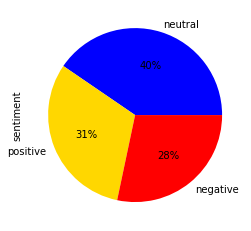

In [7]:
# visualize distribution
tweets_df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [8]:
# transform the sentiment column into numbers
dict_sentiment = {'positive': 1, 'neutral': 0, 'negative': -1}
tweets_df['sentiment'] = tweets_df['sentiment'].apply(lambda x: dict_sentiment.get(x))

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,0
1,sooo sad miss san diego,-1
2,bos bullying,-1
3,interview leave alone,-1
4,son couldnt put release already bought,-1


In [9]:
# create a separate data frame without neutral tweets
tweets_no_neut = tweets_df[tweets_df["sentiment"] != 0]

<AxesSubplot:ylabel='sentiment'>

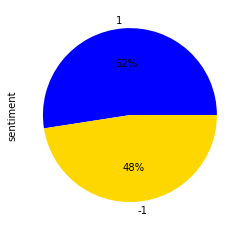

In [10]:
# visualize distribution - without neutral sentiment
tweets_no_neut.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [11]:
# Create the X and y data 
def create_train_test_data (tweets_df, train_size):
    
    # assign X and y to the input and target columns
    X = tweets_df['text']
    y = tweets_df['sentiment']

    # split the data into testing data and training data
    if train_size == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

    # transform the data into tfidf vectors
    # fit the tfidf vectorizer on the training data to avoid bias
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test

In [12]:
# create the model
def create_model(tweets_df, attempt_num, model, train_size):
    # Get the train and test data
    
    X_train_tfidf, X_test_tfidf, y_train, y_test = create_train_test_data (tweets_df, train_size)

    # create a logistic regression model and fit it to the training data
    
    model.fit(X_train_tfidf, y_train)
    training_score, testing_score, recall, precision = evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num)
    
    return training_score, testing_score, recall, precision

In [13]:
# evaluate the model
def evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num):
    
    training_score = model.score(X_train_tfidf, y_train)
    testing_score = model.score(X_test_tfidf, y_test)
    recall = recall_score(y_test.values, model.predict(X_test_tfidf), average='macro')
    precision = precision_score(y_test.values, model.predict(X_test_tfidf), average='macro')
    
    # look at the scores for the testing and training data
    print(f"Attempt {attempt_num} ----------------------------------------")
    print(f"Training Data Score: {model.score(X_train_tfidf, y_train)}")
    print(f"Testing Data Score: {model.score(X_test_tfidf, y_test)} \n")

    # find metrics for testing data
    print(confusion_matrix(y_test.values, model.predict(X_test_tfidf)))
    print(classification_report(y_test.values, model.predict(X_test_tfidf)))
    
    return training_score, testing_score, recall, precision

In [14]:
# create dataframe for attempts
performance_df = pd.DataFrame(columns=["Model", "Attempt Number", "Training Score", "Testing Score", "Parameters", "Recall", "Precision"])
performance_df.head()

,Model,Attempt Number,Training Score,Testing Score,Parameters,Recall,Precision


## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_df, 1, model, 0)
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 1, training_score, testing_score, 'including neutrals', recall, precision]

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_no_neut, 2, model, 0)
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 2, training_score, testing_score, 'excluding neutrals', recall, precision]

0.6843005735740979
<class 'numpy.float64'>
Attempt 1 ----------------------------------------
Training Data Score: 0.8202328966521106
Testing Data Score: 0.6926211614029981 

[[1148  642   98]
 [ 384 2046  320]
 [  90  578 1565]]
              precision    recall  f1-score   support

          -1       0.71      0.61      0.65      1888
           0       0.63      0.74      0.68      2750
           1       0.79      0.70      0.74      2233

    accuracy                           0.69      6871
   macro avg       0.71      0.68      0.69      6871
weighted avg       0.70      0.69      0.69      6871

0.8636739325271872
<class 'numpy.float64'>
Attempt 2 ----------------------------------------
Training Data Score: 0.9302477183833116
Testing Data Score: 0.863847470056221 

[[1669  271]
 [ 286 1865]]
              precision    recall  f1-score   support

          -1       0.85      0.86      0.86      1940
           1       0.87      0.87      0.87      2151

    accuracy            

C:\Users\apfle\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

twitter_classi = RandomForestClassifier(n_estimators=300, random_state=0)

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_df, 1, twitter_classi, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Random Forest', 1, training_score, testing_score, 'including neutrals', recall, precision]

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_no_neut, 2, twitter_classi, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Random Forest', 2, training_score, testing_score, 'excluding neutrals', recall, precision]

0.6950532659463496
<class 'numpy.float64'>
Attempt 1 ----------------------------------------
Training Data Score: 0.9977256186317321
Testing Data Score: 0.7052937966163362 

[[ 882  536  123]
 [ 224 1662  292]
 [  78  367 1333]]
              precision    recall  f1-score   support

          -1       0.74      0.57      0.65      1541
           0       0.65      0.76      0.70      2178
           1       0.76      0.75      0.76      1778

    accuracy                           0.71      5497
   macro avg       0.72      0.70      0.70      5497
weighted avg       0.71      0.71      0.70      5497

0.8579592258157194
<class 'numpy.float64'>
Attempt 2 ----------------------------------------
Training Data Score: 0.9994652406417113
Testing Data Score: 0.8570119156736938 

[[1378  188]
 [ 280 1427]]
              precision    recall  f1-score   support

          -1       0.83      0.88      0.85      1566
           1       0.88      0.84      0.86      1707

    accuracy           

## Extra Trees Classifier

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

twitter_ex = ExtraTreesClassifier(random_state=1)

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_df, 1, twitter_ex, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 1, training_score, testing_score, 'including neutrals', recall, precision]

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_no_neut, 2, twitter_ex, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 2, training_score, testing_score, 'excluding neutrals', recall, precision]

0.7008211560159882
<class 'numpy.float64'>
Attempt 1 ----------------------------------------
Training Data Score: 0.99745269286754
Testing Data Score: 0.7071129707112971 

[[ 967  514   96]
 [ 257 1632  296]
 [  79  368 1288]]
              precision    recall  f1-score   support

          -1       0.74      0.61      0.67      1577
           0       0.65      0.75      0.69      2185
           1       0.77      0.74      0.75      1735

    accuracy                           0.71      5497
   macro avg       0.72      0.70      0.71      5497
weighted avg       0.71      0.71      0.71      5497

0.8631160334451371
<class 'numpy.float64'>
Attempt 2 ----------------------------------------
Training Data Score: 0.9996180290297937
Testing Data Score: 0.8619003971891231 

[[1348  181]
 [ 271 1473]]
              precision    recall  f1-score   support

          -1       0.83      0.88      0.86      1529
           1       0.89      0.84      0.87      1744

    accuracy             

## Ada Boost Classifier

In [18]:
from sklearn.ensemble import AdaBoostClassifier
twitter_ada = AdaBoostClassifier(random_state=1)

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_df, 1, twitter_ada, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 1, training_score, testing_score, 'including neutrals', recall, precision]

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_no_neut, 2, twitter_ada, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 2, training_score, testing_score, 'excluding neutrals', recall, precision]

0.6285464188022528
<class 'numpy.float64'>
Attempt 1 ----------------------------------------
Training Data Score: 0.6583879184861717
Testing Data Score: 0.64744406039658 

[[ 673  825  103]
 [ 182 1744  239]
 [  73  516 1142]]
              precision    recall  f1-score   support

          -1       0.73      0.42      0.53      1601
           0       0.57      0.81      0.66      2165
           1       0.77      0.66      0.71      1731

    accuracy                           0.65      5497
   macro avg       0.69      0.63      0.64      5497
weighted avg       0.68      0.65      0.64      5497

0.8032682188493736
<class 'numpy.float64'>
Attempt 2 ----------------------------------------
Training Data Score: 0.8029029793735676
Testing Data Score: 0.7968224870149709 

[[1431  118]
 [ 547 1177]]
              precision    recall  f1-score   support

          -1       0.72      0.92      0.81      1549
           1       0.91      0.68      0.78      1724

    accuracy             

# Naive Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_df,1,mnb,train_size=0.8)
performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 1, training_score, testing_score, 'including neutrals', recall, precision]

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_no_neut,2,mnb,train_size=0.8)
performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 2, training_score, testing_score, 'excluding neutrals', recall, precision]

0.5889846858897639
<class 'numpy.float64'>
Attempt 1 ----------------------------------------
Training Data Score: 0.7967612809315866
Testing Data Score: 0.6141531744587957 

[[ 603  892   77]
 [ 153 1791  256]
 [  37  706  982]]
              precision    recall  f1-score   support

          -1       0.76      0.38      0.51      1572
           0       0.53      0.81      0.64      2200
           1       0.75      0.57      0.65      1725

    accuracy                           0.61      5497
   macro avg       0.68      0.59      0.60      5497
weighted avg       0.66      0.61      0.61      5497

0.8541889850552696
<class 'numpy.float64'>
Attempt 2 ----------------------------------------
Training Data Score: 0.939572192513369
Testing Data Score: 0.8560953253895509 

[[1264  271]
 [ 200 1538]]
              precision    recall  f1-score   support

          -1       0.86      0.82      0.84      1535
           1       0.85      0.88      0.87      1738

    accuracy            

In [21]:
performance_df.to_csv("Resources/performance.csv")

### MatPlotLib

In [6]:
performance_df = pd.read_csv("Resources/performance.csv")

In [7]:
performance_df

,Unnamed: 0,Model,Attempt Number,Training Score,Testing Score,Parameters,Recall,Precision
0,0,Logistic Regression,1,0.821737,0.687673,including neutrals,0.677963,0.706003
1,1,Logistic Regression,2,0.929677,0.869958,excluding neutrals,0.870180,0.869740
2,2,Random Forest,1,0.997680,0.697653,including neutrals,0.689749,0.710564
3,3,Random Forest,2,0.999389,0.859456,excluding neutrals,0.860892,0.859235
4,4,Extreme Trees,1,0.997498,0.702565,including neutrals,0.697564,0.714053
5,5,Extreme Trees,2,0.999465,0.856095,excluding neutrals,0.856745,0.855810
6,6,Ada Boost,1,0.656523,0.645989,including neutrals,0.627826,0.690963
7,7,Ada Boost,2,0.806264,0.796517,excluding neutrals,0.805284,0.811997
8,8,Multinomial Naive Bayes,1,0.794532,0.625250,including neutrals,0.601418,0.692695
9,9,Multinomial Naive Bayes,2,0.939496,0.847235,excluding neutrals,0.845819,0.850098


In [8]:
performance_neutral = performance_df[performance_df["Parameters"] == "including neutrals"]
performance_no_neutral = performance_df[performance_df["Parameters"] == "excluding neutrals"]

In [9]:
# with neutrals
labels = performance_neutral["Model"].tolist()
training = performance_neutral["Training Score"].tolist()
testing = performance_neutral["Testing Score"].tolist()

training = [round(x, 2) for x in training]
testing = [round(x, 2) for x in testing]

In [10]:
performance_neutral

,Unnamed: 0,Model,Attempt Number,Training Score,Testing Score,Parameters,Recall,Precision
0,0,Logistic Regression,1,0.821737,0.687673,including neutrals,0.677963,0.706003
2,2,Random Forest,1,0.997680,0.697653,including neutrals,0.689749,0.710564
4,4,Extreme Trees,1,0.997498,0.702565,including neutrals,0.697564,0.714053
6,6,Ada Boost,1,0.656523,0.645989,including neutrals,0.627826,0.690963
8,8,Multinomial Naive Bayes,1,0.794532,0.625250,including neutrals,0.601418,0.692695
10,10,Multinomial Naive Bayes,1,0.000000,0.573596,including neutrals,0.573378,0.576831


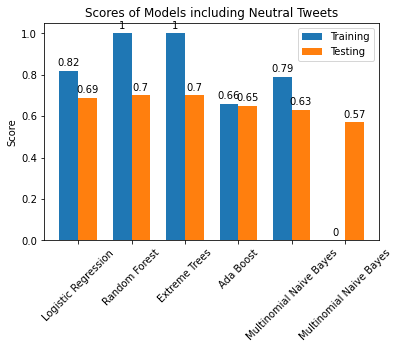

In [11]:
import numpy as np
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training, width, label='Training')
rects2 = ax.bar(x + width/2, testing, width, label='Testing')

ax.set_ylabel('Score')
ax.set_xticks(x, labels, rotation=45)
ax.set_title('Scores of Models including Neutral Tweets')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

In [12]:
# with neutrals
labels = performance_no_neutral["Model"].tolist()
training = performance_no_neutral["Training Score"].tolist()
testing = performance_no_neutral["Testing Score"].tolist()

training = [round(x, 2) for x in training]
testing = [round(x, 2) for x in testing]

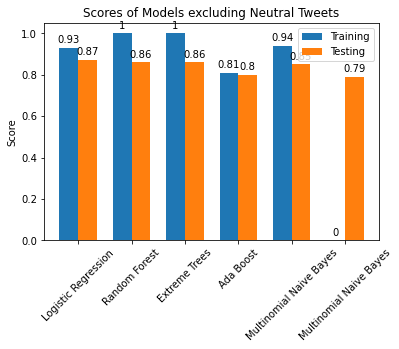

In [13]:
import numpy as np
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training, width, label='Training')
rects2 = ax.bar(x + width/2, testing, width, label='Testing')

ax.set_ylabel('Score')
ax.set_xticks(x, labels, rotation=45)
ax.set_title('Scores of Models excluding Neutral Tweets')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()